# Invariant GP

In [1]:
PATH = "/home/mmahsereci/github/webpage/img/2021-09-06-invariant-gp/"
SAVE= True

# mode = "x-flip"  # same as y-mirror
# mode = "y-flip"  # same as x-mirror
# mode = "point"
# mode = "flip-point"
mode = "rotations"  # set N for N-fold rotation below

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

from matplotlib import colors as mcolors
from matplotlib import cm

import numpy as np
np.random.seed(42)

## Choose orthogonal transformation

In [2]:
from src.invariant_gp.q_funcs import (Q_nfold_rotation, Q_point_mirror_and_y_and_x_flip, \
                                     Q_point_mirror, Q_y_mirror, Q_x_mirror)

D = 2

if mode == "rotations":
    Q_func = Q_nfold_rotation
elif mode == "y-flip":
    Q_func = Q_x_mirror
elif mode == "x-flip":
    Q_func = Q_y_mirror
elif mode == "point":
    Q_func = Q_point_mirror
elif mode == "flip-point":
    Q_func = Q_point_mirror_and_y_and_x_flip
else:
    raise ValueError


`x0` is initial point for set A

In [3]:
from src.invariant_gp.q_funcs import A_nfold

if D==1:
    x0 = np.array([1])
if D==2:
    x0 = np.array([1, 1])
    
N = 5  # for n-fold rotation only
A, G = A_nfold(Q_func, x=x0, N=N, D=D)

In [4]:
A

array([[ 1.        ,  1.        ],
       [ 0.22123174,  1.39680225],
       [-0.64203952,  1.26007351],
       [-1.26007351,  0.64203952],
       [-1.39680225, -0.22123174],
       [-1.        , -1.        ],
       [-0.22123174, -1.39680225],
       [ 0.64203952, -1.26007351],
       [ 1.26007351, -0.64203952],
       [ 1.39680225,  0.22123174]])

In [5]:
G

array([[[ 1.00000000e+00, -0.00000000e+00],
        [ 0.00000000e+00,  1.00000000e+00]],

       [[ 8.09016994e-01, -5.87785252e-01],
        [ 5.87785252e-01,  8.09016994e-01]],

       [[ 3.09016994e-01, -9.51056516e-01],
        [ 9.51056516e-01,  3.09016994e-01]],

       [[-3.09016994e-01, -9.51056516e-01],
        [ 9.51056516e-01, -3.09016994e-01]],

       [[-8.09016994e-01, -5.87785252e-01],
        [ 5.87785252e-01, -8.09016994e-01]],

       [[-1.00000000e+00, -1.22464680e-16],
        [ 1.22464680e-16, -1.00000000e+00]],

       [[-8.09016994e-01,  5.87785252e-01],
        [-5.87785252e-01, -8.09016994e-01]],

       [[-3.09016994e-01,  9.51056516e-01],
        [-9.51056516e-01, -3.09016994e-01]],

       [[ 3.09016994e-01,  9.51056516e-01],
        [-9.51056516e-01,  3.09016994e-01]],

       [[ 8.09016994e-01,  5.87785252e-01],
        [-5.87785252e-01,  8.09016994e-01]]])

# build GP model g

In [6]:
from emukit.quadrature.kernels import QuadratureRBFLebesgueMeasure
from src.invariant_gp.gp import RBF

variance_init = 0.0071
lenthscale_init = 1.1
# lenthscale_init = 0.1
# variance_init = 1.0
integral_bounds = D * [(-3, 3)]
print(lenthscale_init)
print(variance_init)

emukit_rbf = RBF(lengthscale=lenthscale_init, variance=variance_init)
emukit_qrbf = QuadratureRBFLebesgueMeasure(emukit_rbf, integral_bounds=integral_bounds)

1.1
0.0071


## build GP model f (invariant)

In [7]:
from src.invariant_gp.gp import InvariantQuadratureRBFLebesgueMeasure

emukit_iqrbf = InvariantQuadratureRBFLebesgueMeasure(emukit_qrbf, Q=G)

In [8]:
emukit_iqrbf.Q.shape

(10, 2, 2)

# sample from prior of invariant GP

In [9]:
if D==1:
    xmin = integral_bounds[0][0]
    xmax = integral_bounds[0][1]
    zz = np.linspace(xmin, xmax, 200)[:, np.newaxis]
if D==2:
    xmin = -5
    xmax = -xmin
    x = np.linspace(integral_bounds[0][0], integral_bounds[0][1], 40)
    y = np.linspace(integral_bounds[1][0], integral_bounds[1][1], 40)

    xx, yy = np.meshgrid(x, y)
    zz = np.vstack([xx.flatten(), yy.flatten()]).T

K = emukit_iqrbf.K(zz, zz)
print(K.shape)

(1600, 1600)


In [10]:
L = np.linalg.cholesky(K + 1e-8 * np.eye(K.shape[0]))

In [11]:
num_samples = 16 * 2
samples = []
for i in range(num_samples):
    if D==1:
        samples.append(np.reshape(L @ np.random.randn(K.shape[0]), zz.shape))
    if D==2:
        samples.append(np.reshape(L @ np.random.randn(K.shape[0]), [x.shape[0], x.shape[0]]))

/tmp/ipykernel_335103/1368408299.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax[ii, jj].pcolor(xx, yy, samples[i], cmap=cmap) #, vmin=abs(FF).min(), vmax=abs(FF).max())


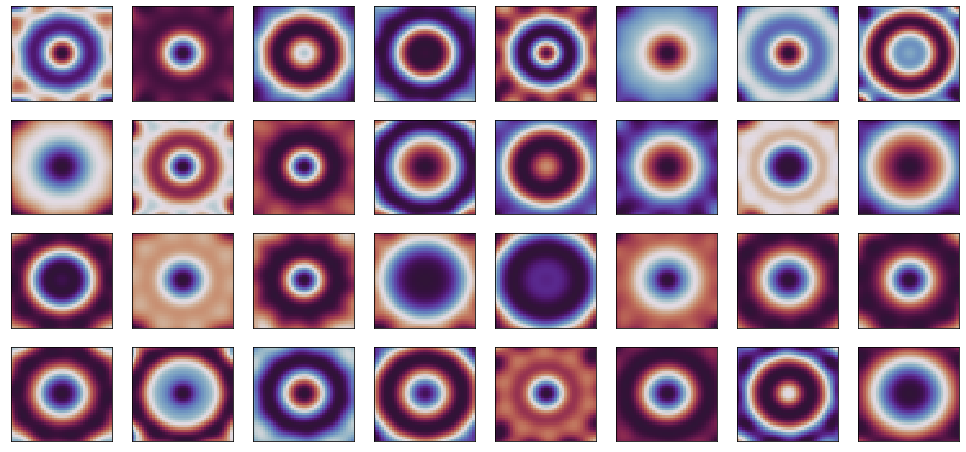

In [13]:
from itertools import cycle
if D==1:
    plt.figure(figsize=(16, 4))
    k = emukit_iqrbf.K(zz, zz)
    m = np.zeros([k.shape[0], 1])
    s = np.sqrt(np.diag(K))[:, np.newaxis]
    for i in range(num_samples):
        plt.plot(zz, samples[i], color='gray')
        plt.plot(x_plot, y_plot, color='k')
        plt.xlim(xmin, xmax)        
        plt.plot(zz, m[:, 0], "C0", label="Mean")
        plt.plot(zz, m + s, "C0")
        plt.plot(zz, m - s, "C0")        
if D==2:
    D1 = 4
    D2 = 8

    cmap = cm.viridis
    cmap = cm.PiYG
    cmap = cm.PRGn
    cmap = cm.BrBG
    cmap = cm.RdBu

#     cmaps = cycle([cm.viridis, cm.PiYG, cm.PRGn, cm.BrBG, cm.RdBu])
    cmaps = cycle([cm.twilight_shifted])

    fig, ax = plt.subplots(D1, D2, figsize=(17, 2*4))
    for i in range(num_samples):
        cmap = next(cmaps)
        ii = int(np.floor(i/D2))
        jj = int(i - ii * D2)
        p = ax[ii, jj].pcolor(xx, yy, samples[i], cmap=cmap) #, vmin=abs(FF).min(), vmax=abs(FF).max())
#         cb = fig.colorbar(p)
        ax[ii, jj].set_xticks([])
        ax[ii, jj].set_yticks([])
        #ax[ii, jj].scatter(A[:, 0], A[:, 1], c='r', label="rotations")
        

# if SAVE:
#     plt.savefig(PATH + mode + "_00.png", bbox_inches = 'tight',pad_inches = 0.05)
# plt.savefig(PATH + mode + "_00_n10.png", bbox_inches = 'tight',pad_inches = 0.05)
    


In [ ]:
emukit_iqrbf._QQ

gray-scale plot

In [ ]:
if D==1:
    plt.figure(figsize=(16, 4))
    k = emukit_iqrbf.K(zz, zz)
    m = np.zeros([k.shape[0], 1])
    s = np.sqrt(np.diag(K))[:, np.newaxis]
    for i in range(num_samples):
        plt.plot(zz, samples[i], color='gray')
        plt.plot(x_plot, y_plot, color='k')
        plt.xlim(xmin, xmax)        
        plt.plot(zz, m[:, 0], "C0", label="Mean")
        plt.plot(zz, m + s, "C0")
        plt.plot(zz, m - s, "C0")        
if D==2:
    D1 = 2 *2
    D2 = 8

    cmap = cm.viridis
    cmap = cm.PiYG
    cmap = cm.PRGn
    cmap = cm.BrBG
    cmap = cm.RdBu

    cmaps = cycle([cm.viridis, cm.PiYG, cm.PRGn, cm.BrBG, cm.RdBu])
    cmaps = cycle([cm.gray])

    fig, ax = plt.subplots(D1, D2, figsize=(17, 2*4))
    for i in range(num_samples):
        cmap = next(cmaps)
        ii = int(np.floor(i/D2))
        jj = int(i - ii * D2)
        p = ax[ii, jj].pcolor(xx, yy, samples[i], cmap=cmap) #, vmin=abs(FF).min(), vmax=abs(FF).max())
#         cb = fig.colorbar(p)
        ax[ii, jj].set_xticks([])
        ax[ii, jj].set_yticks([])
        #ax[ii, jj].scatter(A[:, 0], A[:, 1], c='r', label="rotations")

if SAVE:
    plt.savefig(PATH + mode + "_01.png", bbox_inches = 'tight',pad_inches = 0.05)


## Thumbnail

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))

#     cmap = cm.viridis
#     cmap = cm.PiYG
#     cmap = cm.PRGn
#     cmap = cm.BrBG
#     cmap = cm.RdBu

# plt.pcolor(xx, yy, samples[0], cmap=cm.viridis) #, vmin=abs(FF).min(), vmax=abs(FF).max())
# plt.pcolor(xx, yy, samples[1], cmap=cm.PiYG) #, vmin=abs(FF).min(), vmax=abs(FF).max())
# plt.pcolor(xx, yy, samples[2], cmap=cm.PRGn) #, vmin=abs(FF).min(), vmax=abs(FF).max())
# plt.pcolor(xx, yy, samples[3], cmap=cm.BrBG) #, vmin=abs(FF).min(), vmax=abs(FF).max())
# plt.pcolor(xx, yy, samples[2], cmap=cm.BrBG) #, vmin=abs(FF).min(), vmax=abs(FF).max())
plt.pcolor(xx, yy, samples[2], cmap=cm.twilight_r) #, vmin=abs(FF).min(), vmax=abs(FF).max())

plt.xticks([])
plt.yticks([])
# plt.show()

# plt.savefig(PATH + "thumbnail.png", 
#             bbox_inches = 'tight',pad_inches = 0.05)